# Transfer learning practice

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm



In [2]:
# Define directory paths
data_dir = 'AF_dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


In [3]:
path = 'AF_dataset'
train_info = pd.read_csv(f'{path}/train.csv')

X = train_info[['filename', 'xmin', 'ymin', 'xmax', 'ymax']]
y = train_info['class_id']

data = pd.concat([X, y], axis=1)	

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [4]:
def create_train_test_img_folder(train_df, test_df):
    splits = {'train': train_df, 'test': test_df}
    for split, df in splits.items():
        for i, row in df.iterrows():
            source_file = f'{path}/images/{row["filename"]}'
            class_name = 'pinguin' if row['class_id'] == 1 else 'turtle'
            destination_folder = f'data/{split}'
            os.makedirs(destination_folder, exist_ok=True)
            destination_file = os.path.join(destination_folder)
            shutil.copy(source_file, destination_file)


create_train_test_img_folder(train_data, test_data)

In [5]:
root_dir = 'data'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

In [6]:
class BoundingBoxDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = os.path.join(self.root_dir, row['filename'])
        image = plt.imread(img_name)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Extract bounding box coordinates
        bbox = torch.tensor([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
        
        # Extract class label
        label = torch.tensor(row['class_id'] - 1)  # Subtract 1 to make labels 0-based

        return image, label, bbox


In [7]:
# Data transformations
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load train and test data
train_dataset = BoundingBoxDataset(train_data, root_dir=train_dir, transform=data_transforms)
test_dataset = BoundingBoxDataset(test_data, root_dir=test_dir, transform=data_transforms)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
# Load pretrained VGG-16 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = models.vgg16(pretrained=True)

# Freeze the base model layers
for param in base_model.parameters():
    param.requires_grad = False

# Modify the classifier for dual outputs
class MultiTaskVGG16(nn.Module):
    def __init__(self):
        super(MultiTaskVGG16, self).__init__()
        
        # Base feature extractor
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.flatten = nn.Flatten()
        
        # Shared fully connected layers
        self.shared_fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Classification head
        self.classifier = nn.Linear(4096, 2)  # For 2 classes: penguin and turtle
        
        # Bounding box regression head
        self.regressor = nn.Linear(4096, 4)  # For 4 coordinates: xmin, ymin, xmax, ymax

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        
        class_output = self.classifier(x)
        bbox_output = self.regressor(x)
        
        return class_output, bbox_output

# Initialize model
model = MultiTaskVGG16().to(device)


c:\Users\monte\.conda\envs\images\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\monte\.conda\envs\images\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\monte/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:46<00:00, 11.8MB/s] 


In [9]:
# Loss functions
classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.MSELoss()

# Optimizer (only fine-tuning the final layers)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


In [10]:
# Training function
def train(model, train_loader, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels, bboxes in tqdm(train_loader):
        images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
        
        optimizer.zero_grad()
        class_outputs, bbox_outputs = model(images)
        
        # Compute losses
        class_loss = classification_criterion(class_outputs, labels)
        bbox_loss = regression_criterion(bbox_outputs, bboxes.float())
        loss = class_loss + bbox_loss  # Combine losses
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels, bboxes in tqdm(test_loader):
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            
            class_outputs, bbox_outputs = model(images)
            
            # Compute losses
            class_loss = classification_criterion(class_outputs, labels)
            bbox_loss = regression_criterion(bbox_outputs, bboxes.float())
            loss = class_loss + bbox_loss
            
            running_loss += loss.item() * images.size(0)
            
            # Store predictions and labels for accuracy calculation
            preds = class_outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    epoch_loss = running_loss / len(test_loader.dataset)
    return epoch_loss, accuracy


In [ ]:
# Training loop
num_epochs = 12
best_accuracy = 0.0
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    train_loss = train(model, train_loader, optimizer, device)
    val_loss, val_accuracy = evaluate(model, test_loader, device)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    # Save the model if it has the best accuracy so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model_full.pth")
        print("Saved Best Model!")



Epoch 1/12


100%|██████████| 6/6 [00:22<00:00,  3.80s/it]


Train Loss: 33842.2868
Validation Loss: 14053.5324
Validation Accuracy: 0.6632
Saved Best Model!
Epoch 2/12


100%|██████████| 6/6 [00:21<00:00,  3.58s/it]


Train Loss: 9340.9123
Validation Loss: 7519.2259
Validation Accuracy: 0.8526
Saved Best Model!
Epoch 3/12


100%|██████████| 6/6 [00:21<00:00,  3.62s/it]


Train Loss: 4803.5945
Validation Loss: 5366.7064
Validation Accuracy: 0.7684
Epoch 4/12


100%|██████████| 6/6 [00:21<00:00,  3.60s/it]


Train Loss: 2725.3806
Validation Loss: 4587.0648
Validation Accuracy: 0.8421
Epoch 5/12


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


Train Loss: 2362.1374
Validation Loss: 4767.5081
Validation Accuracy: 0.8632
Saved Best Model!
Epoch 6/12


100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


Train Loss: 1741.4005
Validation Loss: 4539.5115
Validation Accuracy: 0.6737
Epoch 7/12


100%|██████████| 6/6 [00:15<00:00,  2.54s/it]


Train Loss: 1682.6249
Validation Loss: 4921.0139
Validation Accuracy: 0.9579
Saved Best Model!
Epoch 8/12


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


Train Loss: 1923.7635
Validation Loss: 4640.6373
Validation Accuracy: 0.9474
Epoch 9/12


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Train Loss: 1921.1486
Validation Loss: 5102.1616
Validation Accuracy: 0.9684
Saved Best Model!
Epoch 10/12


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


Train Loss: 1818.6328
Validation Loss: 4301.5141
Validation Accuracy: 0.9684
Epoch 11/12


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


Train Loss: 1747.4424
Validation Loss: 5759.4323
Validation Accuracy: 0.9368
Epoch 12/12


100%|██████████| 6/6 [00:14<00:00,  2.41s/it]

Train Loss: 1911.2168
Validation Loss: 4205.3209
Validation Accuracy: 0.9579


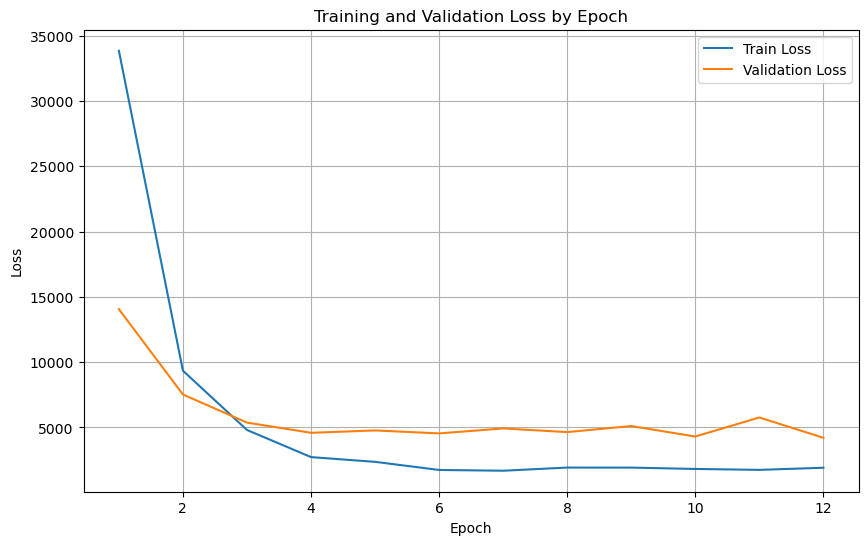

In [ ]:


# Datos de pérdida de entrenamiento y validación por época
train_losses = [33842.2868, 9340.9123, 4803.5945, 2725.3806, 2362.1374, 1741.4005, 1682.6249,
                1923.7635, 1921.1486, 1818.6328, 1747.4424, 1911.2168]
val_losses = [14053.5324, 7519.2259, 5366.7064, 4587.0648, 4767.5081, 4539.5115, 4921.0139,
              4640.6373, 5102.1616, 4301.5141, 5759.4323, 4205.3209]

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss by Epoch')
plt.legend()
plt.grid()
plt.show()


In [12]:
model.load_state_dict(torch.load("best_model_full.pth"))

# Evaluate on the test set
test_loss, test_accuracy = evaluate(model, test_loader, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


100%|██████████| 6/6 [00:14<00:00,  2.50s/it]

Test Loss: 5102.1616
Test Accuracy: 0.9684


In [13]:
# Inference and saving to CSV
def predict_and_save(model, test_loader, device, output_file="submission.csv"):
    model.eval()
    predictions = []
    seen_filenames = set()  # Track unique filenames to avoid duplicates
    
    with torch.no_grad():
        for images, labels, bboxes in test_loader:  # Accepts images, labels, and bboxes
            images = images.to(device)
            class_outputs, bbox_outputs = model(images)
            
            # Get predicted class (1-based indexing)
            class_preds = class_outputs.argmax(dim=1).cpu().numpy() + 1  
            # Get bounding box predictions
            bbox_preds = bbox_outputs.cpu().numpy()
            
            # Assuming filenames are stored as part of the dataset's DataFrame
            for filename, class_id, bbox_pred, label, bbox_true in zip(
                test_loader.dataset.data['filename'], class_preds, bbox_preds, labels.cpu().numpy(), bboxes.cpu().numpy()
            ):
                # Only add unique filenames
                if filename not in seen_filenames:
                    predictions.append([filename, class_id, *bbox_pred, label, *bbox_true])
                    seen_filenames.add(filename)  # Mark this filename as seen
    
    # Save predictions to CSV
    submission_df = pd.DataFrame(predictions, columns=[
        "filename", "pred_class_id", "pred_xmin", "pred_ymin", "pred_xmax", "pred_ymax",
        "true_class_id", "true_xmin", "true_ymin", "true_xmax", "true_ymax"
    ])
    submission_df.to_csv(output_file, index=False)
    
    print(f"Saved predictions to {output_file}")

# Run the prediction and save function
predict_and_save(model, test_loader, device, output_file="submission_full_test.csv")



Saved predictions to submission_full_test.csv


In [14]:
for images in test_loader:
    print(images)

[tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 